In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd src

/Users/purzelrakete/src/github.com/feldberlin/timething/src


In [2]:
from pathlib import Path

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from timething import dataset, job, text, utils, align

# Timething API

Here's an example use of the Timething API. Let's use it to take a look at the alignment for a single track. Let's set up:

In [3]:
# config
fixtures_path = Path("../fixtures")
aligments_path = fixtures_path / "alignments"
metadata = fixtures_path / "text.csv"
cfg = utils.load_config("english")
device = "cpu"

# aligner
ds = dataset.SpeechDataset(Path(metadata), cfg.sampling_rate)
aligner = align.Aligner.build(device, cfg)
ds.clean_text_fn = text.TextCleaner(cfg.language, aligner.vocab)

# loader
loader = DataLoader(
    ds,
    batch_size=3,
    num_workers=1,
    collate_fn=dataset.collate_fn,
    shuffle=False,
)

Let's pull up some recordings:

In [4]:
xs, ys, ys_original, ids  = next(iter(loader))

In [5]:
for y, y_original, id in zip(ys, ys_original, ids):
    print(f"{id}: '{y_original}'. Cleaned: '{y}'")
    display(ipd.Audio(fixtures_path / id))

audio/one.mp3: 'One!'. Cleaned: 'one'


audio/two.mp3: 'Two?'. Cleaned: 'two'


audio/born.mp3: 'Born in 1969 in Belgrade.'. Cleaned: 'born|in|nineteen|sixty-nine|in|belgrade'


Let's align them.

In [6]:
alignments = aligner.align((xs, ys, ys_original, ids))

/usr/local/Caskroom/miniforge/base/envs/timething/lib/python3.9/site-packages/transformers-4.4.2-py3.8.egg/transformers/models/wav2vec2/modeling_wav2vec2.py:704: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


The last example: Born in 1969 in Belgrade:

In [7]:
recording_idx = 2
id = ids[recording_idx]
y = ys[recording_idx]
y_original = ys_original[recording_idx]
alignment = alignments[recording_idx]

First let's take a look at the frame-wise log probabilities.

Visualisations taken from the [pytorch alignment tutorial](https://pytorch.org/tutorials/intermediate/forced_alignment_with_torchaudio_tutorial.html), Original Author: Moto Hira <moto@fb.com>.

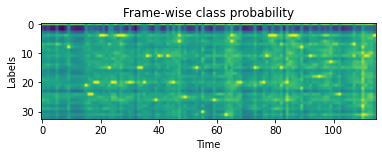

In [8]:
plt.imshow(alignment.scores)
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels");

In [9]:
alignment.chars_cleaned

[Segment(label='b', start=0, end=14, score=1.0280994144236293e-05),
 Segment(label='o', start=15, end=15, score=1.3207172632876655e-12),
 Segment(label='r', start=16, end=17, score=1.3206710986921197e-12),
 Segment(label='n', start=18, end=19, score=7.4409094357441e-14),
 Segment(label='|', start=20, end=22, score=4.585884740579358e-16),
 Segment(label='i', start=23, end=23, score=1.357695703519101e-17),
 Segment(label='n', start=24, end=25, score=2.2302035096686808e-17),
 Segment(label='|', start=26, end=29, score=8.725735945737972e-18),
 Segment(label='n', start=30, end=33, score=4.0870931628408693e-23),
 Segment(label='i', start=34, end=34, score=8.190235507939179e-24),
 Segment(label='n', start=35, end=35, score=8.190173021639553e-24),
 Segment(label='e', start=36, end=38, score=2.4556122196876898e-23),
 Segment(label='t', start=39, end=39, score=8.182865414485366e-24),
 Segment(label='e', start=40, end=42, score=2.4519342056320752e-23),
 Segment(label='e', start=43, end=44, score=

In [10]:
alignment.words_cleaned

[Segment(label='born', start=0, end=19, score=7.99632885640586e-06),
 Segment(label='in', start=23, end=25, score=1.2119810733475182e-17),
 Segment(label='nineteen', start=30, end=46, score=2.545663353983283e-23),
 Segment(label='sixty-nine', start=49, end=77, score=1.6639531000623603e-24),
 Segment(label='in', start=82, end=85, score=2.939367296354774e-26),
 Segment(label='belgrade', start=89, end=114, score=3.92305471556761e-27)]

In [11]:
padding_ms = 20
padding_seconds = padding_ms / 1000

def show_words(words):
    for word in words:
        start_seconds = max(0, alignment.model_frames_to_seconds(word.start) + padding_seconds)
        end_seconds = alignment.model_frames_to_seconds(word.end) + padding_seconds
        y, sr = utils.load_slice(fixtures_path / id, start_seconds, end_seconds)
        print(f"{word.label} ({word.start}:{word.end})")
        ipd.display(ipd.Audio(y, rate=sr))
        
show_words(alignment.words_cleaned)

born (0:19)


in (23:25)


nineteen (30:46)


sixty-nine (49:77)


in (82:85)


belgrade (89:114)


Looks reasonable. Now for the original versions:

In [12]:
alignment.chars

[Segment(label='B', start=0, end=14, score=1.0280994144236293e-05),
 Segment(label='o', start=15, end=15, score=1.3207172632876655e-12),
 Segment(label='r', start=16, end=17, score=1.3206710986921197e-12),
 Segment(label='n', start=18, end=19, score=7.4409094357441e-14),
 Segment(label=' ', start=20, end=22, score=4.585884740579358e-16),
 Segment(label='i', start=23, end=23, score=1.357695703519101e-17),
 Segment(label='n', start=24, end=25, score=2.2302035096686808e-17),
 Segment(label=' ', start=26, end=29, score=8.725735945737972e-18),
 Segment(label='1969', start=30, end=77, score=4.0870931628408693e-23),
 Segment(label=' ', start=78, end=81, score=4.094535604655688e-25),
 Segment(label='i', start=82, end=83, score=4.134729040972845e-26),
 Segment(label='n', start=84, end=85, score=3.7225151068098765e-26),
 Segment(label=' ', start=86, end=88, score=1.950112518818188e-26),
 Segment(label='B', start=89, end=91, score=3.8031879908892284e-27),
 Segment(label='e', start=92, end=94, sco

In [13]:
alignment.words

[Segment(label='Born', start=0, end=19, score=7.99632885640586e-06),
 Segment(label='in', start=23, end=25, score=1.2119810733475182e-17),
 Segment(label='1969', start=30, end=77, score=3.8443242944332105e-23),
 Segment(label='in', start=82, end=85, score=2.939367296354774e-26),
 Segment(label='Belgrade.', start=89, end=114, score=3.92305471556761e-27)]

In [14]:
show_words(alignment.words)

Born (0:19)


in (23:25)


1969 (30:77)


in (82:85)


Belgrade. (89:114)
